In [ ]:
# default_exp storm

# Stormtracks

> calculate stormtracks from SLP fields

In [ ]:
#hide
import numpy as np
import xarray as xr
from tqdm import tqdm
import logging

from xarray.core.variable import Variable

logger = logging.getLogger(__name__)
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

try:
    import dask
except:
    logger.warning("Dask is not installed in your python environment. Xarray Dataset parallel computing will not work.")


# plotting
try:
    import matplotlib.pyplot as plt
    #import cartopy.crs as ccrs
except:
    logger.warning("Matplotlib and/or Cartopy is not installed in your python environment. Xarray Dataset plotting functions will not work.")



In [ ]:
#export
class storm():

    def __init__(self, filename="", ds=None, anomaly = True, **kwargs):
        """The constructor for storm track class. Initialize a storm instance.
        
        If filename is given, try to load it directly.
        Arguments to the load function can be passed as key=value argument.
        Parameters
        ----------
            filename : string
                Datapath + filename.nc
            ds : dataset
                xarray dataset
            anomaly: bool
                calculates anomaly in time
        """
        
        self._anomaly = anomaly
        
        if not filename:
            if ds is None:
                self.ds = None
            else:
                self.ds = ds
            return
        
        try:
            self.ds = None
            self.read(filename, **kwargs)
        except (OSError, IOError, RuntimeError):
            try:
                self.read(filename, **kwargs)
            except Exception:
                raise IOError("Unkown fileformat. Known formats are netcdf.")

  
    def __repr__(self):
        try:
            string = "\
            Xarray dataset with {} time steps. \n\
            Available fields: {}".format(
                self.ntime, ", ".join(self.variables)
            )
        except AttributeError:
            # Assume it's an empty Blocking()
            string = "\
            Empty contrack container.\n\
            Hint: use read() to load data."
        return string

    def __str__(self):
        return 'Class {}: \n{}'.format(self.__class__.__name__, self.ds)
  
    def __len__(self):
        return len(self.ds)
    
    def __getattr__(self, attr):
        if attr in self.__dict__:
            return getattr(self, attr)
        return getattr(self.ds, attr)

    
    def __getitem__(self, key):
        return self.ds[key]

    @property
    def ntime(self):
        """Return the number of time steps"""
        if len(self.ds.dims) != 3:
            logger.warning(
                "\nBe careful with the dimensions, "
                "you want dims = 3 and shape:\n"
                "(latitude, longitude, time)"
            )
            return self.ds.dims[self._get_name_time()]
        return self.ds.dims[self._get_name_time()]

    @property
    def variables(self):
        """Return the names of the variables"""
        return list(self.ds.data_vars)
    
    @property
    def dimensions(self):
        """Return the names of the dimensions"""
        return list(self.ds.dims)
    
    @property
    def grid(self):
        """Return the number of longitude and latitude grid"""
        if len(self.ds.dims) != 3:
            logger.warning(
                "\nBe careful with the dimensions, "
                "you want dims = 3 and shape:\n"
                "(latitude, longitude, time)"
            )
            return None
        string = "\
        latitude: {} \n\
        longitude: {}".format(
            self.ds.dims[self._get_name_latitude()], self.ds.dims[self._get_name_longitude()]
        ) 
        print(string)

    @property
    def dataset(self):
        """Return the dataset"""
        return self.ds

# ----------------------------------------------------------------------------
# Read / Import / Save data
    
    def read(self, filename, **kwargs):
        """
        Reads a file into a xarray dataset.
        
        Parameters
        ----------
            filename : string
                Valid path + filename
        """
        if self.ds is None:
            self.ds = xr.open_dataset(filename, **kwargs)
            if self._anomaly == True:
                self.ds = self.ds - self.ds.mean(self._get_name_time())
            logger.debug('read: {}'.format(self.__str__))
        else:
            errmsg = 'contrack() is already set!'
            raise ValueError(errmsg)
            
    def read_xarray(self, ds):
        """
        Read an existing xarray data set.
        
        Parameter:
        ----------
            ds: data set
                Valid xarray data set.
        """
        if self.ds is None:
            if not isinstance(ds, xr.core.dataset.Dataset):
                errmsg = 'ds has to be a xarray data set!'
                raise ValueError(errmsg)
            self.ds = ds
            logger.debug('read_xarray: {}'.format(self.__str__))
        else:
            errmsg = 'contrack() is already set!'
            raise ValueError(errmsg)
 
# Set up / Check dimensions
   
    def set_up(self,
               time_name=None,
               longitude_name=None,
               latitude_name=None,
               force=False,
               write=True
    ):
        """
        Prepares the dataset for storm tracking. Does consistency checks
        and tests if all required information is available. Sets (automatically 
        or manually) internal variables and dimensions.
        Parameters
        ----------
            time_name : string, optional
                Name of time dimension. The default is None.
            longitude_name : string, optional
                Name of longitude dimension. The default is None.
            latitude_name : string, optional
                Name of latitude dimension. The default is None.
            force=False: bool, optional 
                Skip some consistency checks.
            write=True: bool, optional
                Print name of dimensions.
        Returns
        -------
            None.
        """

        # set dimensions
        if time_name is None:
            self._time_name = self._get_name_time()  
        else:
            self._time_name = time_name
        if longitude_name is None:
            self._longitude_name = self._get_name_longitude()
        else:
            self._longitude_name = longitude_name
        if latitude_name is None:
            self._latitude_name = self._get_name_latitude()
        else:
            self._latitude_name = latitude_name

        # set resolution
        if (self._longitude_name and self._latitude_name) is not None:
            self._dlon =  self._get_resolution(self._longitude_name, force=force)
            self._dlat =  self._get_resolution(self._latitude_name, force=force)

        if self._time_name is not None:
            self._dtime = self._get_resolution(self._time_name, force=force)
       
        # Transpose data
        self.ds = self.ds.transpose(self._time_name,
                                    self._latitude_name,
                                    self._longitude_name) 
        # print names    
        if write:
            logger.info(
                "\n time: '{}'\n"
                " longitude: '{}'\n"
                " latitude: '{}'\n".format(
                self._time_name, 
                self._longitude_name,
                self._latitude_name)
            )

    
    def _get_name_time(self):
        """
        check for 'time' dimension and return name
        """
        # check unit
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs and
                'since' in self.ds[dim].attrs['units']) or 
                ('units' in self.ds[dim].encoding and
                 'since' in self.ds[dim].encoding['units']) or
                dim in ['time']):
                return dim
        # check dtype
        for dim in self.ds.variables:
            try:
                var = self.ds[dim].data[0]
            except IndexError:
                var = self.ds[dim].data
            if isinstance(var, datetime64):
                return dim   
        # no 'time' dimension found
        logger.warning(
            "\n 'time' dimension (dtype='datetime64[ns]') not found."
        )
        return None     


    def _get_name_longitude(self):
        """
        check for 'longitude' dimension and return name
        """
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs and
               self.ds[dim].attrs['units'] in ['degree_east', 'degrees_east']) or
               dim in ['lon', 'longitude', 'x']):
               return dim
        # no 'longitude' dimension found
        logger.warning(
            "\n 'longitude' dimension (unit='degrees_east') not found."
        )
        return None


    def _get_name_latitude(self):
        """
        check for 'latitude' dimension and return name
        """
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs  and
                self.ds[dim].attrs['units'] in ['degree_north', 'degrees_north']) or
                dim in ['lat', 'latitude', 'y']):
                return dim
        # no 'latitude' dimension found
        logger.warning(
            "\n 'latitude' dimension (unit='degrees_north') not found."
        )
        return None
            
    def _get_resolution(self, dim, force=False):
        """
        set spatial (lat/lon) and temporal (time) resolution
        """
        # time dimension in hours
        if dim == self._time_name:
            try:
                var = self.ds[dim].to_index()
                delta = np.unique((
                    self.ds[dim].to_index()[1:] - 
                    self.ds[dim].to_index()[:-1])
                    .astype('timedelta64[h]')
                )
            except AttributeError:  # dates outside of normal range
                # we can still move on if the unit is "days since ..."
                if ('units' in self.ds[dim].attrs and
                    'days' in self.ds[dim].attrs['units']):
                    var = self.ds[dim].data
                    delta = np.unique(var[1:] - var[:-1])
                else:
                    errmsg = 'Can not decode time with unit {}'.format(
                        self.ds[dim].attrs['units'])
                    raise ValueError(errmsg)
        # lat/lon dimension in Degree
        else:
            delta = abs(np.unique((
                self.ds[dim].data[1:] - 
                self.ds[dim].data[:-1])
            ))
        # check resolution
        if len(delta) > 1:
            errmsg = 'No regular grid found for dimension {}.\n\
            Hint: use set_up(force=True).'.format(dim)
            if force and dim != self._time_name:
                logging.warning(errmsg)
                logmsg = ' '.join(['force=True: using mean of non-equidistant',
                                   'grid {}'.format(delta)])
                logging.warning(logmsg)
                delta = round(delta.mean(), 2)
            else:
                if dim == self._time_name:
                    logging.warning(errmsg)
                else:
                    raise ValueError(errmsg)
        elif delta[0] == 0:
            errmsg = 'Two equivalent values found for dimension {}.'.format(
                dim)
            raise ValueError(errmsg)
        elif delta[0] < 0:
            errmsg = ' '.join(['{} not increasing. This should',
                                   'not happen?!']).format(dim)
            raise ValueError(errmsg)
            
        return delta

    def _harmonicRegression(self, data, N):
        """Returns Fourier coefficients"""
        result = np.zeros((N, 2))
        T = len(data)
        t = np.arange(T)
        for n in range(N):
            result[n,0] = 2/T*(data * np.cos(2*np.pi*n*t/T)).sum()
            result[n,1] = 2/T*(data * np.sin(2*np.pi*n*t/T)).sum()
        return result

    def derivative(self, variable, N = 20, dim = "", order = 1):
        """
        Calculates the first and second derivative in dimension 
        of choice, applying a harmonic regression.
        See Benestad et al. (2006)        
        """  
        dp = np.zeros((self.ds[variable].data.shape))

        if dim == self._time_name:
            print("Calculating d/dt for all lon, lat points ...")
            for i in tqdm(range(len(self.ds[self._latitude_name]))):
                for ii in range(len(self.ds[self._longitude_name])):
                    dp[:, i, ii] =  self._calc_dX(self.ds[variable].data[:, i, ii], N, order)
        elif dim == self._latitude_name:
            print("Calculating d/dlat for all time, lon points ...")
            for i in tqdm(range(len(self.ds[self._time_name]))):
                for ii in range(len(self.ds[self._longitude_name])):
                    dp[i, :, ii] =  self._calc_dX(self.ds[variable].data[i, :, ii], N, order)
        elif dim == self._longitude_name:
            print("Calculating d/dlon for all time, lat points ...")
            for i in tqdm(range(len(self.ds[self._time_name]))):
                for ii in range(len(self.ds[self._latitude_name])):
                    dp[i, ii, :] =  self._calc_dX(self.ds[variable].data[i, ii, :], N, order)
        else:
            errmsg = "{} is not found.".format(dim)

        if order == 1:
            self.ds['dd{}{}'.format(dim, variable)] = ([self._time_name, self._latitude_name, self._longitude_name], dp)
        if order == 2:
            self.ds['d2d{}{}'.format(dim, variable)] = ([self._time_name, self._latitude_name, self._longitude_name], dp)

    def _calc_dX(self, data, N, order):
        """
        Calculation of the derivative using harmonic regression (Fourier fit)
        """
        if np.isnan(data).all() == True:
            return 
        
        mask = np.isfinite(data)
        T = len(data[mask])
        t = np.arange(T)

        data = data - data.mean()
        
        if N > T:
            N = T
             
        anbn = self._harmonicRegression(data[mask], N)


        Wi = 2 * np.pi / T

        dp = 0 

        if order == 1:
            for i in range(0, N):
                dp = dp + (Wi * (-anbn[i,0]*np.sin(Wi*i*t)+anbn[i,1]*np.cos(Wi*i*t)))
        elif order == 2:
            for i in range(0, N):
                dp = dp + (Wi**2 * (-anbn[i,0]*np.cos(Wi*i*t) - anbn[i,1]*np.sin(Wi*i*t)))
        else:
            print("Your selection of order {} is not possible. Only 1th and 2nd derivative possible.")

            

        tmp = data.copy()
        tmp[mask] = dp

        return tmp

## Harmonic regression

Concept of harmonic regression

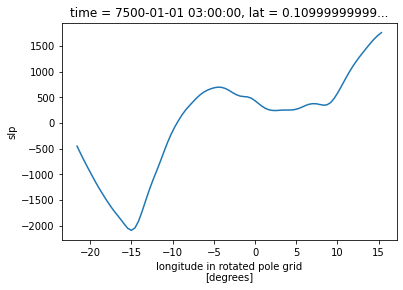

In [ ]:
ds = xr.open_dataset("data/rca_unrot_data_1_5.nc", use_cftime = True)
ds = ds.rename({"rlon":"lon", "rlat":"lat"})
data = ds.sel(lat=0, method="nearest").slp.isel(time = 1)
data = data - data.mean()
data.plot()

In [ ]:
N = 20 # Number of harmonics
result = []
T = len(data)
t = np.arange(T)
for n in range(N+1):
    an = 2/T*(data * np.cos(2*np.pi*n*t/T)).sum()
    bn = 2/T*(data * np.sin(2*np.pi*n*t/T)).sum()
    result.append((an, bn))
anbn = np.array(result)

<StemContainer object of 3 artists>

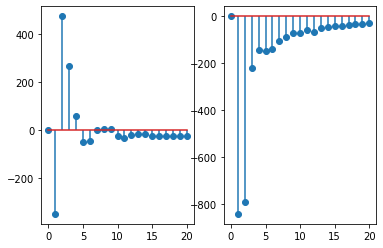

In [ ]:
plt.subplot(121); plt.stem(anbn[:,0], use_line_collection=True)
plt.subplot(122); plt.stem(anbn[:,1], use_line_collection=True)

Reconstruct the signal.

In [ ]:
result = 0
T = len(data)
t = np.arange(T)/T
for n, (a, b) in enumerate(anbn):
    if n == 0:
        a = a/2
    result = result + a*np.cos(2*np.pi*n*t) + b * np.sin(2*np.pi*n*t)

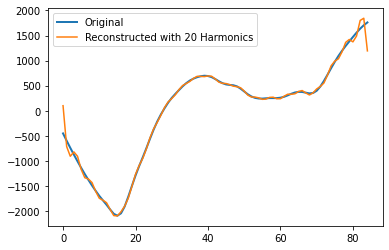

In [ ]:
plt.plot(data, label='Original', lw=2)
plt.plot(result, label='Reconstructed with {} Harmonics'.format(N))
plt.legend()

This fit can then be differentiated.

First derivative

In [ ]:
Wi = 2 * np.pi / len(data)
t = np.arange(len(data))

an, bn = anbn[:,0], anbn[:,1]

dp = 0
for i in range(0, N):
    dp = dp + (Wi * (-an[i]*np.sin(Wi*i*t)+bn[i]*np.cos(Wi*i*t)))
    
zero_crossings = np.where(np.diff(np.signbit(dp)))[0]
zero_crossings

array([14, 47, 54, 76])

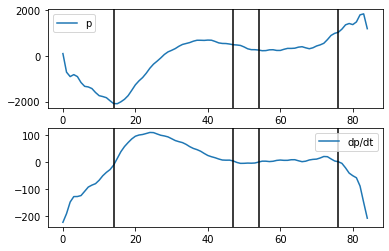

In [ ]:
f, (ax, bx) = plt.subplots(2,1)

bx.plot(dp, label = "dp/dt")
for point in zero_crossings:
    bx.axvline(x = point, color = "black")
    
ax.plot(result, label = "p")

for point in zero_crossings:
    ax.axvline(x = point, color = "black")

ax.legend(); bx.legend()

Repeat with storm package

In [ ]:
obj = storm(ds = ds)
obj.set_up(force = True)

            Hint: use set_up(force=True).
            Hint: use set_up(force=True).
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'



In [ ]:
obj = storm(ds = ds)
obj.set_up(force = True)
obj.derivative("slp", N = 10, dim = "lon") 
obj.derivative("slp", N = 10, dim = "lon", order = 2)  

            Hint: use set_up(force=True).
            Hint: use set_up(force=True).
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

 60%|██████    | 3/5 [00:00<00:00, 24.22it/s]

Calculating d/dlon for all time, lat points ...


100%|██████████| 5/5 [00:00<00:00, 24.93it/s]

Calculating d/dlon for all time, lat points ...


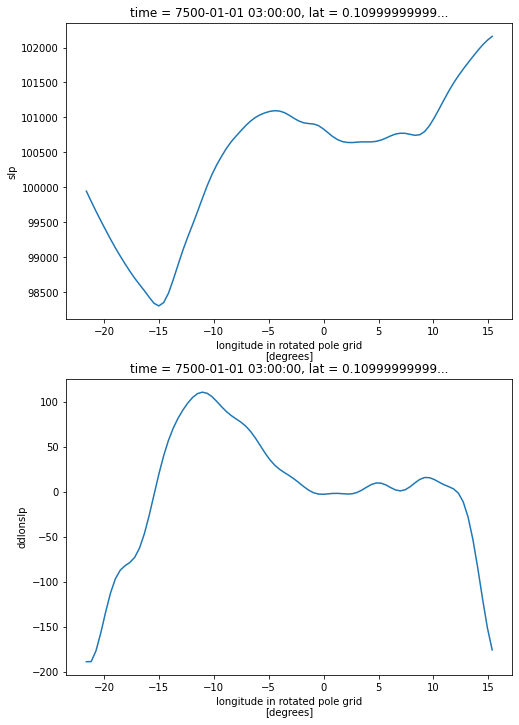

In [ ]:
f, ax = plt.subplots(2,1,figsize= (8,12))
obj.ds.isel(time = 1).sel(lat = 0, method = "nearest").slp.plot(ax = ax[0], label = "p")
obj.ds.isel(time = 1).sel(lat = 0, method = "nearest").ddlonslp.plot(ax = ax[1], label = "dp/dx")

## Apply to 2D slp data

We need a grid without nan values

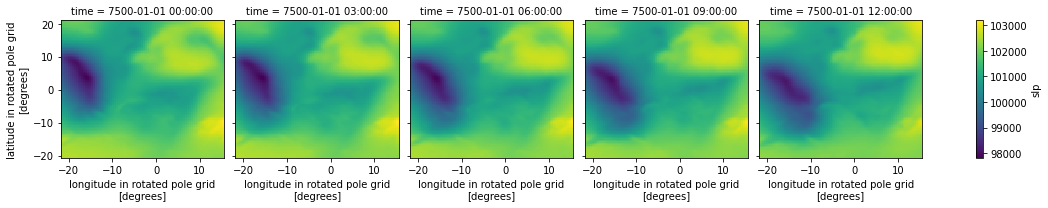

In [ ]:
obj.ds.isel(time = slice(0,5)).slp.plot(col = "time", col_wrap = 5)

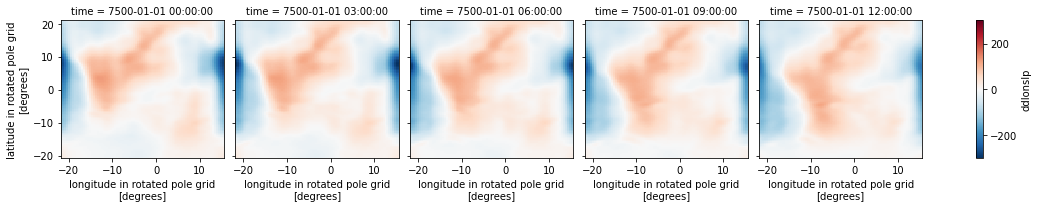

In [ ]:
obj.ds.isel(time = slice(0,5)).ddlonslp.plot(col = "time", col_wrap = 5)

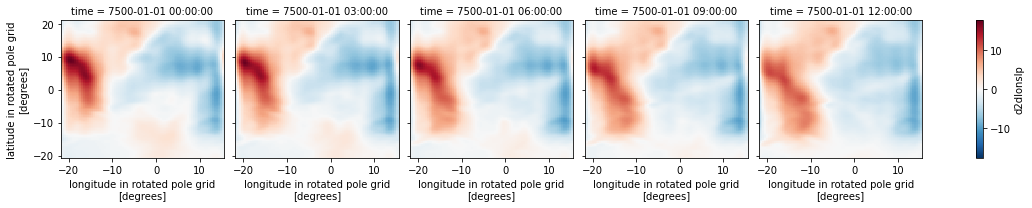

In [ ]:
obj.ds.isel(time = slice(0,5)).d2dlonslp.plot(col = "time", col_wrap = 5)